<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#GP-Regression" data-toc-modified-id="GP-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>GP Regression</a></span><ul class="toc-item"><li><span><a href="#Set-up-training-data" data-toc-modified-id="Set-up-training-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Set up training data</a></span></li><li><span><a href="#Setting-up-the-model" data-toc-modified-id="Setting-up-the-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Setting up the model</a></span></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Make-predictions-with-the-model" data-toc-modified-id="Make-predictions-with-the-model-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Make predictions with the model</a></span></li><li><span><a href="#Plot-the-model-fit" data-toc-modified-id="Plot-the-model-fit-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Plot the model fit</a></span></li></ul></li><li><span><a href="#GP-Regression-with-Uncertain-Inputs" data-toc-modified-id="GP-Regression-with-Uncertain-Inputs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GP Regression with Uncertain Inputs</a></span><ul class="toc-item"><li><span><a href="#Set-up-training-data" data-toc-modified-id="Set-up-training-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set up training data</a></span></li><li><span><a href="#Setting-up-the-model" data-toc-modified-id="Setting-up-the-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Setting up the model</a></span></li><li><span><a href="#Training-the-model-with-uncertain-features" data-toc-modified-id="Training-the-model-with-uncertain-features-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training the model with uncertain features</a></span></li></ul></li></ul></div>

# GPyTorch

GPyTorch. Gaussian processes for modern machine learning systems. l

Requirements:

Python >= 3.6

PyTorch >= 1.8.1


##  Introduction

In this tutorial we will implement a Gaussian processes by using a  Regression with a Gaussian noise model 

## GP Regression

Adapted from https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

In this notebook we use GPyTorch top train an RBF kernel Gaussian process on a simple function.

\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, \sqrt{0.04}) \equiv  N(\mu, \sigma^{2}) 
\end{align}




In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

###  Set up training data

In [27]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)


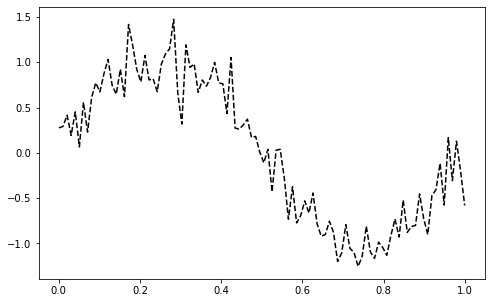

In [28]:
# Show function
FIGSIZE = (8, 5)
plt.figure(figsize=FIGSIZE)
plt.plot(train_x, train_y,'k--')

###  Setting up the model

For most GP regression models, you will need to construct the following GPyTorch objects:
1. A GP Model (gpytorch.models.ExactGP) 
2. A Likelihood (gpytorch.likelihoods.GaussianLikelihood) 
3. A Mean  (gpytorch.means.ConstantMean())
4. A Kernel (gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
5. A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) 


In [18]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Training the model

In [19]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.938   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.906   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.873   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.836   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.794   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.748   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.699   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.648   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.600   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.557   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.517   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.481   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.448   lengthscale: 0.273   noise: 0.259
Iter 14/50 - Loss: 0.415   lengthscale: 0.257   noise: 0.237
Iter 15/50 - Loss: 0.383   lengthscale: 0.244   noise: 0.216
Iter 16/50 - Loss: 0.352   lengthscale: 0.234   noise: 0.197
Iter 17/50 - Loss: 0.321   length

### Make predictions with the model

- f_preds = model(test_x)
- y_preds = likelihood(model(test_x))

- f_mean = f_preds.mean
- f_var = f_preds.variance
- f_covar = f_preds.covariance_matrix
- f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [20]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

###  Plot the model fit

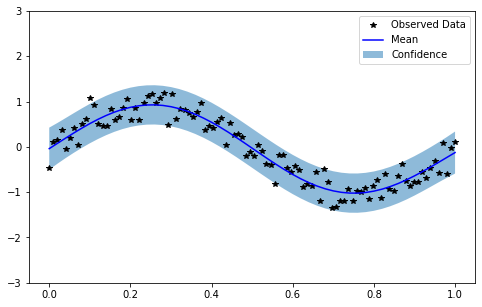

In [21]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

##  GP Regression with Uncertain Inputs

- Now we're going to demonstrate one way of dealing with uncertainty in our training data. Let's say that we're collecting training data that models the following function.

\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2) 
\end{align}

- However, now assume that we're a bit uncertain about our features. In particular, we're going to assume that every `x_i` value is not a point but a distribution instead. E.g.

$$ x_i \sim \mathcal{N}(\mu_i, \sigma_i). $$

- To deal with this uncertainty, we'll use variational inference (VI) in conjunction with stochastic optimization. At every optimization iteration, we'll draw a sample `x_i` from the input distribution.


In [30]:
import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In the next cell, we set up the training data for this example. We'll be using 20 regularly spaced points on [0,1].
We'll represent each of the training points $x_i$ by their mean $\mu_i$ and variance $\sigma_i$

In [32]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2

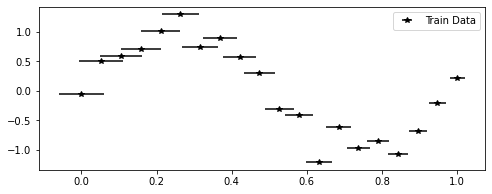

In [33]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x_mean, train_y, xerr=(train_x_stdv * 2), fmt="k*", label="Train Data")
ax.legend()

###  Setting up the model

- we're performing VI to deal with the feature uncertainty, we'll be using a `~gpytorch.models.
- we'll use a `VariationalStrategy` and a `CholeskyVariationalDistribution` to define our posterior approximation.

In [34]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


inducing_points = torch.randn(10, 1)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

### Training the model with uncertain features

In [35]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 400


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

iterator = tqdm.notebook.tqdm(range(training_iter))
for i in iterator:
    # First thing: draw a sample set of features from our distribution
    train_x_sample = torch.distributions.Normal(train_x_mean, train_x_stdv).rsample()
    
    # Now do the rest of the training loop
    optimizer.zero_grad()
    output = model(train_x_sample)
    loss = -mll(output, train_y)
    iterator.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

  0%|          | 0/400 [00:00<?, ?it/s]

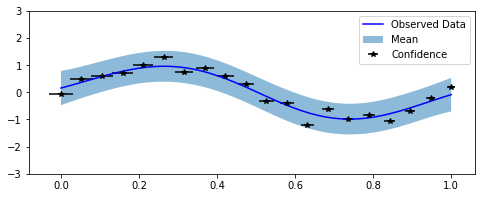

In [36]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x_mean.numpy(), train_y.numpy(), xerr=train_x_stdv, fmt='k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])